## 1. 环境设置与路径配置

In [6]:
import sys
import os
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from unittest.mock import MagicMock

# 1. 添加 Time-Series-Library 到路径，以便导入 models.PatchTST 和 layers
ts_lib_path = Path(r'D:\Time_Series_Library\Time-Series-Library')
if str(ts_lib_path) not in sys.path:
    sys.path.insert(0, str(ts_lib_path))

# Mock reformer_pytorch and einops to avoid ImportError if not installed
# PatchTST uses FullAttention which doesn't depend on these, 
# but SelfAttention_Family.py imports them at top level.
try:
    import reformer_pytorch
except ImportError:
    print("reformer_pytorch not found, mocking it...")
    sys.modules['reformer_pytorch'] = MagicMock()
    sys.modules['reformer_pytorch'].LSHSelfAttention = MagicMock()

try:
    import einops
except ImportError:
    print("einops not found, mocking it...")
    sys.modules['einops'] = MagicMock()

# 2. 添加 TPLC_Net 到路径，以便导入 tplc_algo (用于数据加载)
def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(10):
        if (cur / 'tplc_algo').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    # 如果找不到，尝试硬编码路径（根据你的工作区结构）
    fallback = Path(r'D:\degree_code\scheme_1\TPLC_Net')
    if fallback.exists():
        return fallback
    raise RuntimeError('未找到 TPLC_Net 根目录')

try:
    # 从当前文件位置开始找
    ROOT = find_project_root(Path.cwd())
except:
    # 如果当前路径不对，尝试从已知路径找
    ROOT = find_project_root(Path(r'D:\degree_code\scheme_1\TPLC_Net'))

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('Time-Series-Library Path:', ts_lib_path)
print('Project Root:', ROOT)

# 导入 PatchTST
try:
    from models.PatchTST import Model as PatchTSTModel
    print("Successfully imported PatchTSTModel")
except ImportError as e:
    print(f"Import Error: {e}")
    print("请检查 D:\Time_Series_Library\Time-Series-Library 是否存在且包含 models/PatchTST.py")

# 导入数据加载工具
from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders

einops not found, mocking it...
Time-Series-Library Path: D:\Time_Series_Library\Time-Series-Library
Project Root: D:\degree_code\scheme_1\TPLC_Net
Successfully imported PatchTSTModel


## 2. 配置参数

In [7]:
class Configs:
    def __init__(self):
        # 任务类型
        self.task_name = 'short_term_forecast' # 或 'long_term_forecast'
        
        # 数据相关
        self.seq_len = 96       # 输入序列长度
        self.pred_len = 24      # 预测序列长度
        self.enc_in = 0         # 输入特征数 (稍后根据数据更新)
        
        # 模型超参
        self.d_model = 128      # 隐层维度
        self.n_heads = 4        # 注意力头数
        self.e_layers = 2       # Encoder 层数
        self.d_ff = 256         # FFN 维度
        self.dropout = 0.1
        self.activation = 'gelu'
        self.factor = 1         # Attention factor
        
        # PatchTST 特有
        self.patch_len = 16
        self.stride = 8
        
        # 训练相关
        self.batch_size = 32
        self.learning_rate = 0.001
        self.epochs = 10

configs = Configs()

## 3. 加载数据

In [8]:
# 自动定位数据集路径
candidates = [
    ROOT.parent / 'datasets' / '自主温室挑战赛',
    ROOT.parent.parent / 'datasets' / '自主温室挑战赛',
    Path(r'D:\学位会\数据集\温室环境数据(4万条)') # 备用路径
]
dataset_root = None
for p in candidates:
    if p.exists():
        dataset_root = p
        break

if dataset_root is None:
    # 如果找不到，请手动指定
    # dataset_root = Path(r'你的数据路径')
    print("Warning: 自动寻找数据集路径失败，请手动指定 dataset_root")
else:
    print(f"Dataset root found: {dataset_root}")

team = 'AICU'

if dataset_root:
    prepared = prepare_greenhouse_datasets(
        dataset_root=dataset_root,
        team=team,
        seq_len=configs.seq_len,
        pred_len=configs.pred_len,
        stride=1,
    )
    
    train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=configs.batch_size)
    
    # 更新 configs.enc_in
    configs.enc_in = len(prepared.feature_cols)
    print(f"Input features (enc_in): {configs.enc_in}")
    print(f"Feature columns: {prepared.feature_cols}")
    print(f"Target columns: {prepared.target_cols}")

Dataset root found: D:\degree_code\scheme_1\datasets\自主温室挑战赛


D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Input features (enc_in): 101
Feature columns: ['AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC', 'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR', 'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_vip', 'co2_dos', 'co2_vip', 'dx_vip', 'int_blue_sp', 'int_blue_vip', 'int_farred_sp', 'int_farred_vip', 'int_red_sp', 'int_red_vip', 'int_white_sp', 'int_white_vip', 'pH_drain_PC', 'scr_blck_vip', 'scr_enrg_vip', 't_heat_vip', 't_vent_sp', 't_ventlee_vip', 't_ventwind_vip', 'water_sup', 'water_sup_intervals_vip_min', 'Stem_elong', 'Stem_thick', 'Cum_trusses', 'stem_dens ', 'EC_slab1', 'EC_slab2', 'WC_slab1', 'WC_slab2', 't_slab1', 't_slab2', 'irr_PH', 'irr_EC', 'irr_NH4', 'irr_K', 'irr_Na', 'irr_Ca', 'irr_Mg', 'irr_Si', 'irr_NO3', 'irr_Cl', 'irr_SO4', 'irr_HCO3', 'irr_PO4', 'irr_Fe', 'irr_Mn', 'irr_Zn', 'irr_B', 'irr_Cu', 'irr_Mo', 'drain_PH', 'drain_EC', 'drain_NH4', 'drain_K', 'drain_Na', 'drain_Ca', 'drain_Mg', 'drain_Si', 'drain_NO3', 'drain_Cl', 'drain_SO4', 

## 4. 初始化模型

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PatchTSTModel(configs, patch_len=configs.patch_len, stride=configs.stride).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs.learning_rate)
criterion = torch.nn.MSELoss()

Using device: cuda


## 5. 训练循环

In [10]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, (batch_x, batch_y) in enumerate(loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        
        optimizer.zero_grad()
        
        # PatchTST forward: x_enc, x_mark_enc, x_dec, x_mark_dec
        # 这里我们只有 x (batch_x) 和 y (batch_y)
        # PatchTST 通常只需要 x_enc 进行预测
        # x_mark_enc, x_dec, x_mark_dec 可以传 None 或 zeros，视具体实现而定
        # 查看 PatchTST.py 源码，forward 签名: forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None)
        # 且 forecast 方法只用了 x_enc
        
        outputs = model(batch_x, None, None, None)
        
        # outputs shape: [B, pred_len, D]
        # batch_y shape: [B, pred_len, D_out]
        # 如果 enc_in != target_dim (例如多变量输入单变量预测)，需要切片
        
        # 假设是多变量预测多变量 (M-M) 或者 PatchTST 输出维度等于 enc_in
        f_dim = -1 if configs.task_name == 'short_term_forecast' else 0
        outputs = outputs[:, -configs.pred_len:, f_dim:]
        batch_y = batch_y[:, -configs.pred_len:, f_dim:]

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            outputs = model(batch_x, None, None, None)
            
            f_dim = -1 if configs.task_name == 'short_term_forecast' else 0
            outputs = outputs[:, -configs.pred_len:, f_dim:]
            batch_y = batch_y[:, -configs.pred_len:, f_dim:]

            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    return total_loss / len(loader)

if dataset_root:
    print("Start Training...")
    for epoch in range(configs.epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{configs.epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Start Training...
Epoch 1/10 | Train Loss: 1.8247 | Val Loss: 4.3659
Epoch 2/10 | Train Loss: 1.8306 | Val Loss: 4.3623
Epoch 3/10 | Train Loss: 1.8239 | Val Loss: 4.3583
Epoch 4/10 | Train Loss: 1.8241 | Val Loss: 4.3560
Epoch 5/10 | Train Loss: 1.8242 | Val Loss: 4.3659
Epoch 6/10 | Train Loss: 1.8238 | Val Loss: 4.3613
Epoch 7/10 | Train Loss: 1.8231 | Val Loss: 4.3641
Epoch 8/10 | Train Loss: 1.8223 | Val Loss: 4.3580
Epoch 9/10 | Train Loss: 1.8262 | Val Loss: 4.3574
Epoch 10/10 | Train Loss: 1.8247 | Val Loss: 4.3545


## 6. 可视化结果

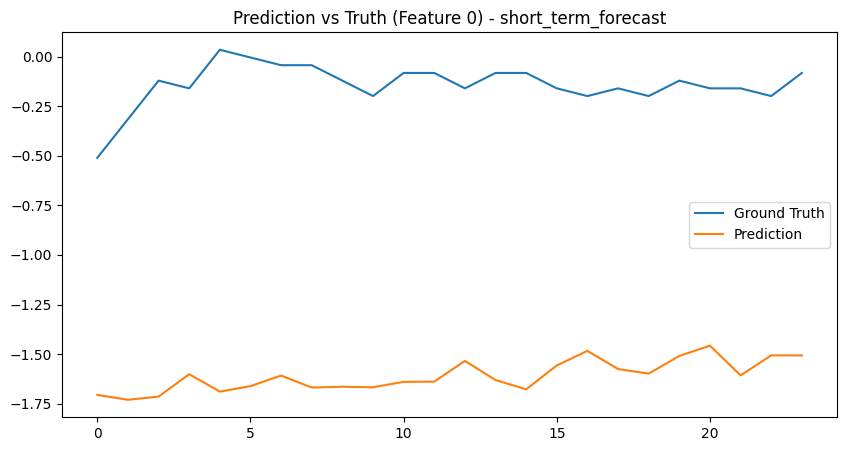

In [11]:
if dataset_root:
    model.eval()
    x, y = next(iter(test_loader))
    x = x.float().to(device)
    
    with torch.no_grad():
        pred = model(x, None, None, None)
    
    # 取第一个样本
    true_seq = y[0].cpu().numpy()
    pred_seq = pred[0].cpu().numpy()
    
    # 反标准化 (如果需要)
    # true_seq = prepared.target_scaler.inverse_transform(true_seq)
    # pred_seq = prepared.target_scaler.inverse_transform(pred_seq)
    
    # 绘制第一个特征
    plt.figure(figsize=(10, 5))
    plt.plot(true_seq[:, 0], label='Ground Truth')
    plt.plot(pred_seq[:, 0], label='Prediction')
    plt.title(f'Prediction vs Truth (Feature 0) - {configs.task_name}')
    plt.legend()
    plt.show()